# An Intro to Predictive Modeling for Customer Lifetime Value (CLV) -- Tutorial Notebook 

In this notebook, you will be introduced to the workflow necessary to train a Pareto/NBD model (e.g. Schmittlein et al. 1987) on a transactional dataset. An extension to the Pareto/NBD model includes predictions for the monetary value as well (Gamma-Gamma model -- Fader et al. 2004). 

The Pareto/NBD model is a good introductory probabilistic model to the non-contractual setting with continous purchase opportunity. It's a simple enough model that is easy to train and generally produces good results when the assumptions behind the model are met. It's a good first shot at CLV modeling ! 


## A few words on the CDNOW Dataset 
The CDNOW dataset is a very popular dataset used in academic papers addressing CLV models. CDNOW used to be an online retailer of CDs in the 1990's. The dataset in question includes the transactional data of a cohort of customers who have made their first purchase in the first quarter of 1997. All transactions from these customers between their purchase and June 1998 are included. The transactional data was downsampled to contain transactions of 10% of the customers population (2357 customers). 

The CDNOW dataset is a good example of a non-contractual setting with a continuous purchasing opportunity. It has been used extensively in the CLV literature.


## A Few Warnings/Disclaimers : 
* In this notebook, I favored code simplicity over performance. Some of you may find that operations done on dataframes and in the STAN code could be optimized for performance. That is certainly the case.
* The sample log-likelihood of the Pareto/NBD model can be derived analytically and model parameters can be found via standard optimization routines. In principle, one does not have to use STAN to obtain the parameters of the Pareto/NBD model. The purpose of the STAN code is to allow users to potentially extend the model beyond sample log-likelihoods that cannot be expressed analytically and require MCMC evaluation.
* The main focus of this notebook is to predict the purchase count. I left it for you as an exercise to implement the gamma-gamma model for the monetary value component, as described in this paper by Fader et al. (2005). I put the solution at the bottom of the notebook.


## Requirements 
This notebook was tested with 
* ipython version 3.0.0 
* Mac OS X El Captian version 10.11.6

We recommend a few Gb of RAM (2-3).

Please download and place the file `cdnow_transaction_log.csv` in the same directory as this file. 

# Training a Pareto/NBD Model on the CDNOW Dataset 

In [5]:
# Doing the necessary installations. You can install these from your notebook or 
# from a terminal window if you are prompted for a password. 

# You may have to do `sudo pip ...` for some or all all of the packages below. 

#!pip install numpy==1.12.0 
#!pip install pandas==0.19.2
#!pip install scipy==0.18.1
#!pip install matplotlib==2.0.0
#!pip install pickle
#!pip install cython==0.23.5
#!pip install pystan==2.10.0

In [6]:
# Doing all the necessary imports here 

import pandas
import os 
import sys 
import pandas as pd
import numpy as np 
import pystan 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime 
from scipy.stats import gaussian_kde
from hashlib import md5
%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

# if you are having issues with matplotlib on macosx, I recommend taking a look 
# at this stakoverflow thread : 
# http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python 
# 1) cd ~/.matplotlib
# 2) vim matplotlibrc
# 3) add to the file :  backend: TkAgg
# 4) restart the ipython kernel 

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Import the dataset into a Pandas DataFrame 

In [7]:
# Load the cdnow dataset into a Pandas DataFrame

transactions = pd.read_csv('cdnow_transaction_log.csv')

In [8]:
# Lets Explore the dataframe

transactions.head(15)

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34
5,21,1997-01-13,11.77
6,50,1997-01-01,6.79
7,60,1997-02-01,21.75
8,71,1997-01-01,13.97
9,86,1997-01-01,23.94


The dataframe has the familiar structure of a transactional dataset. There is a column for customer ID, a transaction date and the amount of the transaction. We have everything we need to train the model. 

In [11]:
# Lets convert the data field into a datetime object : 

transactions['date'] = pd.to_datetime(transactions['date'])

# Exploration of the Transactional Data 

Here we're going to do some basic exploration of the dataset. For the readers who are already familiar with the CDNOW dataset, go to the "Compute the RFM Dataframe" section directly 

In [12]:
# total number of transactions 

transactions.shape 

(6695, 3)

In [14]:
transactions.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


In [16]:
# Number of customers : 

transactions.groupby(['cust']).size().shape

(2357,)

In [17]:
# date range of the dataset : 

transactions['date'].min(), transactions['date'].max()

(Timestamp('1997-01-01 00:00:00'), Timestamp('1998-06-30 00:00:00'))

The dataset spans 1.5 year of data. A natural breakdown would be to train on one year of data and validate on the following 6 months. 

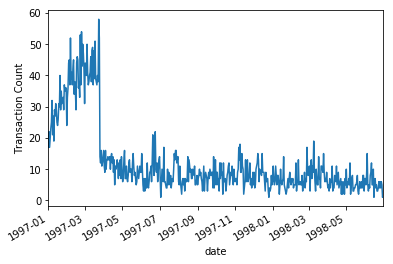

In [18]:
# Time series of the number of transactions (daily) 

ts_transactions = transactions.groupby(['date']).size()
plt.ylabel('Transaction Count') 
ts_transactions.plot()

The chart above looks at the number of transactions per day for the 2357 customers in this dataset. As you probably 
noticed, there is a sharp break in the counts at the end of `1997-03`. That is because the dataset only includes the customers who made their first purchase in the first quarter of 1997. If the dataset would have also included the customers who made their first purchase post 1997-Q1, the count per day would have likely continued to increase. 

This is a standard practice when modeling CLV. The cohorts of customers used to train the models are generally based on their time of first purchase. That way, one can study the evolution of the population parameters over time and pinpoint possible problems in the long run. 

The drawback of using such cohort-based approach is that you have fewer datapoints to constrain the priors parameters. 

In [19]:
transactions.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


In [20]:
# Let's take a look at the typical inter-purchase time and IPT distribution 

def shift_date(x): 
    x['shifted_date'] = x['date'].shift(-1) 
    return x

# We'll apply a shift of -1 between the 'date' column and a newly shifted date column shift_date. 
# That way, we'll be able to subtract date from shifted_date at the customer level and compute 
# the inter purchase time (IPT) directly : 
transactions_tmp = transactions.sort_values(['date']).\
                        groupby(['cust'], as_index=True).apply(shift_date)    

# Let's re-order by customer and date : 
transactions_tmp.sort_values(['cust','date'], ascending=True, inplace=True)
transactions_tmp.dropna(inplace=True)

# Compute the IPT in days : 
transactions_tmp['IPT'] = (transactions_tmp['shifted_date'] - transactions_tmp['date']).apply(lambda x : x.days)

transactions_tmp.head(5) 

,cust,date,sales,shifted_date,IPT
0,4,1997-01-18,29.73,1997-08-02,196
1,4,1997-08-02,14.96,1997-12-12,132
4,21,1997-01-01,63.34,1997-01-13,12
10,111,1997-01-01,35.99,1997-01-11,10
11,111,1997-01-11,32.99,1997-03-15,63


In [21]:
# let's print the mean IPT. Our training period of 365 days is long enough. 

print(transactions_tmp['IPT'].mean())

70.87298294144767


(0, 270)

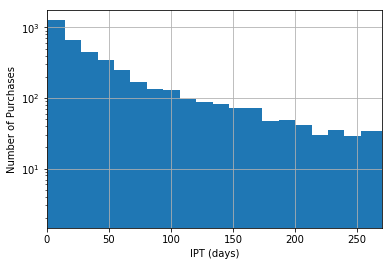

In [22]:
# Distribution of IPT : 

transactions_tmp['IPT'].hist(bins=40)
plt.yscale('log')
plt.xlabel('IPT (days)') 
plt.ylabel('Number of Purchases') 

# 275 (365-90) days to avoid right censorship issues. 
plt.xlim([0,270])

1 44


Text(0, 0.5, 'Number of Customers')

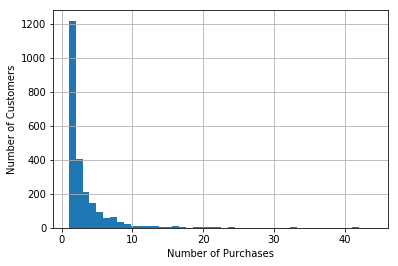

In [23]:
# Let's look at the distribution of the number of purchases per customer : 

n_purchases = transactions.groupby(['cust']).size()
print(n_purchases.min(axis=0), n_purchases.max(axis=0))
n_purchases.hist(bins=(n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1)
plt.xlabel('Number of Purchases') 
plt.ylabel('Number of Customers') 

As we see in the figure above, more than 50% (1200/2357) of the customers made only a single purchase in the 1.5 year period covered by the dataset. 

# Compute the RFM Dataframe 

In this section, we will generate the recency-frequency-monetary value (RFM) object. 

* Recency : time between first and last transaction
* Frequency : here frequency really refers to repeat frequency, i.e. the number of purchases beyond the initial one. i.e. repeat frequency = purchase counts - 1 )
* monetary value : mean of all the transactions in the training periods 
* T : time between first purchase and end of calibration period 

RFM data structures are used to constrain the Pareto/NBD and BG/NBD models. Extensions to the RFM structure are needed for the Pareto/GGG model (Platzer & Reutterer 2016) or to include the clumpiness estimate (Zhang et al. 2015), for example. 

In [24]:
# Select calibration and holdout periods 
# Lets select a training period of one year and and a holdout period of 6 months. 

end_calibration = pd.to_datetime('1997-12-31')
train = transactions[transactions.date <= end_calibration]
holdout = transactions[transactions.date > end_calibration]

## Bin transactions by day

In [25]:
# Sum the monetary value by customer and by date : 

train2 = train.sort_values(['date'], ascending=True).groupby(['cust', 'date'], 
                                                             as_index=False)['sales'].sum()

In [26]:
# Let's take a look at the data : 

train2.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


In [27]:
# let's define a single function that can be applied at the customer level and 
# compute all the relevant RFM quantities at once : 

def compute_rfm(x, end_calibration): 
    x['recency'] = (x['date'].max() - x['date'].min()).days
    x['frequency'] = x['date'].count()-1
    x['T'] = (end_calibration - x['date'].min()).days
    x['monetary_value'] = x['sales'].mean()
    return x

In [28]:
# use the function compute_rfm to compute recency, frequency, T and monetary value 
# for each group (each customer). 

train3 = train2.groupby(['cust']).apply(lambda x: compute_rfm(x, end_calibration))

In [29]:
# Let's look at the data : 

train3.head()

,cust,date,sales,recency,frequency,T,monetary_value
0,4,1997-01-18,29.73,328,2,347,23.723333
1,4,1997-08-02,14.96,328,2,347,23.723333
2,4,1997-12-12,26.48,328,2,347,23.723333
3,18,1997-01-04,14.96,0,0,361,14.960000
4,21,1997-01-01,63.34,12,1,364,37.555000


In [30]:
# lets take the first row for each customer and only the relevant columns of interest. 

rfm = train3[['cust', 'recency', 'frequency', 'T', 'monetary_value']].groupby(['cust']).first()

In [31]:
# Let's look at the results : 

rfm.head()

,recency,frequency,T,monetary_value
cust,,,,
4,328,2,347,23.723333
18,0,0,361,14.960000
21,12,1,364,37.555000
50,0,0,364,6.790000
60,0,0,333,21.750000


In [32]:
# Let's look at the range of values for each column. Make sure the results make sense 
# before going any further with the analysis. No NaNs, 
# no negative values, no recency > 364 days, etc.  

rfm.describe()

,recency,frequency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,75.550276,1.352143,321.003818,32.836897
std,110.231161,2.792310,23.277967,31.103740
min,0.000000,0.000000,281.000000,0.000000
25%,0.000000,0.000000,301.000000,14.990000
50%,0.000000,0.000000,321.000000,24.883333
75%,150.000000,2.000000,340.000000,39.245000
max,362.000000,37.000000,364.000000,506.970000


The results look good so far! You could also take a look at the distribution of recency, frequency, T, and monetary value. before going any further. 


# Train a simple Pareto/NBD Model over the training/holdout period. 

Now that we have an RFM vector for each customer and for the training period (`rfm` dataframe above), let's train the Pareto/NBD object). For this step, we're going to use the python API to the STAN library. <a href="mc-stan.org">STAN</a> is a probabilistic langauge and has been used in many fields, including physics, engineering, and business. STAN provides APIs for several languages including R, Python, Matlab, and Julia. 

The script below is divided into 4 parts : 

* data (the raw data) 
* parameters (the model parameters that have to be evaluated) 
* model (code of the model) 

The individual-level likelihood function of the Pareto/NBD model can be easily derived (e.g. Schmittlein et al. 1987; Fader et al. 2005) and will be used in the STAN code below : 
$$ L(\lambda, \mu | x, t_x, T) = \frac{\lambda^x \mu}{\lambda+\mu}e^{-(\lambda+\mu)t_x}+\frac{\lambda^{x+1}}{\lambda+\mu}e^{-(\lambda+\mu)T} $$

As discussed during the webcast, $\lambda$ is the count rate that goes in the Poisson distribution and $\mu$ is the slope of the lifetime exponential distribution. The typical lifetime corresponds to $\sim 1/\mu$. 

The priors for $\lambda$ and $\mu$ are gamma distributed : 
$$g(\lambda|r,\alpha) = \frac{\alpha^r}{\Gamma(r)}\lambda^{r-1}e^{-\lambda \alpha} $$
and 
$$g(\mu|s,\beta) = \frac{\beta^s}{\Gamma(s)}\mu^{s-1}e^{-\mu \beta} \; . $$ 

For each of the four model parameters $(r,\alpha,s,\beta)$, I assigned hyperpriors that are normally distributed. 

In [33]:
# Training the STAN model over several 1000's iterations can take a long time. 
# I recommend running the STAN models for at least 5000 iterations with a warmup 
# of a few 100. To get a thorough understanding of the code below and the fit results, 
# I highly recommend reading the STAN documentation. 

# Although running a STAN model is not necessary to solve a Pareto/NBD model, 
# it allows you to extend/change the model with ease. 

paretonbd_model="""
data{
int<lower=0> n_cust; //number of customers 
vector<lower=0>[n_cust] x; 
vector<lower=0>[n_cust] tx; 
vector<lower=0>[n_cust] T; 
}

parameters{
// vectors of lambda and mu for each customer. 
// Here I apply limits between 0 and 1 for each 
// parameter. A value of lambda or mu > 1.0 is unphysical 
// since you don't enough time resolution to go less than 
// 1 time unit. 
vector <lower=0,upper=1.0>[n_cust] lambda; 
vector <lower=0,upper=1.0>[n_cust] mu;

// parameters of the prior distributions : r, alpha, s, beta. 
// for both lambda and mu
real <lower=0>r;
real <lower=0>alpha;
real <lower=0>s;
real <lower=0>beta;
}

model{

// temporary variables : 
vector[n_cust] like1; // likelihood
vector[n_cust] like2; // likelihood 

// Establishing hyperpriors on parameters r, alpha, s, and beta. 
r ~ normal(0.5,0.1);
alpha ~ normal(10,1);
s ~ normal(0.5,0.1);
beta ~ normal(10,1);

// Establishing the Prior Distributions for lambda and mu : 
lambda ~ gamma(r,alpha); 
mu ~ gamma(s,beta);

// The likelihood of the Pareto/NBD model : 
like1 = x .* log(lambda) + log(mu) - log(mu+lambda) - tx .* (mu+lambda);
like2 = (x + 1) .* log(lambda) - log(mu+lambda) - T .* (lambda+mu);

// Here we increment the log probability density (target) accordingly 
target+= log(exp(like1)+exp(like2));
}
"""

# here's the data we will provide to STAN : 
data={'n_cust':len(rfm),
    'x':rfm['frequency'].values,
    'tx':rfm['recency'].values,
    'T':rfm['T'].values
}

In [34]:
# STAN models can take a while to fit. Let's pickle the model to disk as a precautionary measure. 
# We can always read the model from disk later on. Note that this file is sizable > 100 MB. 

# Utility function to pull a stan model that has been pickled. 
# from pystan docs : https://pystan.readthedocs.io/en/latest/avoiding_recompilation.html
def stan_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm.sampling(**kwargs)

iterations = 1000
warmup = 500

# I recommend training for several 1000's iterations. Here we run the STAN model : 
pareto_nbd_fit = stan_cache(paretonbd_model, model_name='paretonbd_model', \
                                  data=data, chains=1, iter=iterations, warmup=warmup)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76111598b747c5ab299e594dcfa74504 NOW.


CompileError: command 'gcc' failed with exit status 1

In [35]:
# Here we'll extract the traces for the lambda and mu parameters. We get the posterior 
# distribution of these parameters for "free" when using STAN. 

trace = pareto_nbd_fit.extract()
lambdas = trace['lambda']
mus = trace['mu']

NameError: name 'pareto_nbd_fit' is not defined

# Comparisons Between Model Predictions and Training Set Observations 

Here we will perform a series of comparisons between the model predictions in the training period vs the observations over the same period of time. 

The fit above gives us all four model parameters $(r,\alpha,s,\beta)$. Furthermore, the MCMC chain also gives us the values of $\lambda,\mu$ for each customer. Given $(\lambda,\mu)$ it becomes relatively easy to derive the expected number of purchases made by each customer in the period $(0,t]$ : 
$$ E[X(t)~|~\lambda, \mu] = \frac{\lambda}{\mu}-\frac{\lambda}{\mu}e^{-\mu t } $$

In the expression above, X(t) represents the number of (repeat) purchases between 0 and $t$. 

Parameters $\lambda$ and $\mu$ and latent parameters. They are not observed. However, the MCMC sampling technique allows us to extract the joint posterior distribution of $\lambda$ and $\mu$ at the customer level. This is very handy. Indeed, one simply has to evaluate the expression above for all the pairs of $\lambda$ and $\mu$ included in the MCMC trace. This is a fairly straightforward process. We show how one can do this in the cells below.  

## Scatter Plot of the Purchase Counts : Observations vs Predictions 

In [36]:
# Here I take the expectation (mean) value of E[X(t) | lambda, mu] over the trace values of lambda and mu : 

dt_train = 365.0 # 12 months 
training_predictions = (lambdas/mus-lambdas/mus*np.exp(-mus*dt_train)).mean(axis=0)
rfm['model_train_count'] = training_predictions 

NameError: name 'lambdas' is not defined

In [37]:
rmse_train_count = (rfm['model_train_count'] - rfm['frequency']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(rfm))
print('RMSE =', rmse_train_count)

KeyError: 'model_train_count'

In [38]:
def plot_scatter(dataframe, colx, coly, xlabel='Observed Counts', 
                 ylabel='Predicted Counts', 
                 xlim=[0,15], ylim=[0,15], density=True): 
    """This function will plot a scatter plot of colx on the x-axis vs coly on the y-axis. 
    If you want to add a color to indicate the density of points, set density=True
    
    Args : 
        - dataframe (dataframe) : pandas dataframe containing the data of interest 
        - colx (str) : name of the column you want to put on the x axis 
        - coly (str) : same but for the y axis 
        - xlabel (str) : label to put on the x axis 
        - ylabel (str) : same for y axis 
        - xlim (list) : defines the range of x values displayed on the chart 
        - ylim (list) same for the y axis. 
        - density (bool) : set True to add color to indicate density of point. 
        
    """

    if not density : 
        plt.scatter(dataframe[colx].values, dataframe[coly].values)
    else:
        xvals = dataframe[colx].values
        yvals = dataframe[coly].values
        xy = np.vstack([xvals, yvals])
        z = gaussian_kde(xy)(xy)
        plt.scatter(xvals, yvals, c=z, s=10, edgecolor='')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.linspace(xlim[0], xlim[1], 100), 
             np.linspace(ylim[0], ylim[1], 100), 
             color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot()

In [39]:
# Let's see the scatter plot predicted vs observed purchase counts in the training period. 

plot_scatter(rfm, 'frequency', 'model_train_count')

KeyError: 'model_train_count'

Not bad. Though this is expected given that this dataset was used to train the model. A more meaningful comparison would be done on a holdout period that the model has not seen yet. That's what we'll do below. 

I recommend adding to the diagnostics scatter plot above. A few suggestions include : 
* A chart showing the residuals per observed counts. This may indicate where the model performs poorly. 
* A cumulative distribution function (CDF) of the total number of purchases. This will be useful to determine whether or not the model can be used to forecast demand for this particular cohort of customers 

**All of these and more advanced diagnostics are accessible to our <a href="https://www.datascience.com/products">DataScience Cloud Platform customers</a> in our CLV Playbook and Library. Coming soon **

# Comparisons Between Predictions and the Holdout (validation) Set Observations

As discussed below, we will now take a look at the holdout period. 

In the case of the holdout data, we have to condition the number of future purchases on the probability that the customer is alive at the end of the calibration period, $T$. After all, if a customer is dead at $T$, this customer should not make future purchases.

This leads to a different expression than $E[X(t) | \lambda, \mu]$ for the purchase count **beyond the calibration period**. In the expression below, $Y$ is the number of purchases in the period $dt$ where $dt$ corresponds to the interval $(T, T+dt]$. In a nutshell, one has to condition $Y(dt)$ on the fact that the customer is alive at $T$. The expression below illustrates that:  

$$ E[Y(dt)~|~\lambda, \mu, x, t_x, T] = E[Y(dt) | \lambda, \mu, \rm{alive~at} T ] \times P(\tau > T | \lambda, \mu x, t_x, T)$$

You may have noticed that I have not defined the expression $P(\tau > T)$ yet. This expression corresponds to the probability that the lifetime of a customer $\tau$ exceeds the length of the calibration period $T$. In other words, it corresponds to the probability that a customer is alive at $T$. For the sake of brevity, I will not go over the derivation of $P(\tau > T)$ (though I invite the reader to do so) and will rather give you the final expression : 

$$P(\tau > T|\lambda, \mu, x, t_x, T) = \frac{1}{1+\mu/(\mu+\lambda)[e^{(\lambda + \mu)(T-t_x)}-1]} \; .$$


As for the expression for $E[Y(dt) | \lambda, \mu, \rm{alive~at~}T ]$ it corresponds to : 

$$ E[Y(dt) | \lambda, \mu, \rm{alive~at~}T ] = \frac{\lambda}{\mu}-\frac{\lambda}{\mu}e^{-\mu dt } \; .$$

As you may have noticed, it is the same expression as for $E[X(t)|\lambda,\mu]$. I will not go into the derivation of this expression but the reason why these two expressions are the same is due to the memoryless nature of the exponential distribution. 

As mentioned before, $\lambda$ and $\mu$ are unobserved but the MCMC process gives us the joint posterior distribution of those parameters at the customer level. One simply has to compute $E[Y(dt)~|~\lambda, \mu, x, t_x, T]$ for each value of $\lambda$ and $\mu$ in the customer-level trace and compute the mean value. 


In [40]:
def prob_alive_at_T(lam, mu, t_x, T): 
    """Computes the probability of being alive at T given lambda, mu, t_x, and T"""
    return 1 / ( 1 + mu / (mu + lam) * (np.exp((lam + mu) * (T - t_x)) - 1) )

In [41]:
# Predictions made over the holdout period of 6 months : 
dt_hold = 180.0 # 6 months 

# Here we extract recency and T values: 
tmp = rfm['T'].values 
T_values = np.tile(tmp, [iterations - warmup, 1])
tmp2 = rfm['recency'].values 
recency_values = np.tile(tmp2, [iterations - warmup, 1])

# Holdout counts predictions : 
holdout_predictions = ((lambdas/mus - lambdas/mus*np.exp(-mus*dt_hold)) * \
                                prob_alive_at_T(lambdas, mus, recency_values, T_values)).mean(axis=0)

#holdout_predictions = (lambdas/mus - lambdas/mus*np.exp(-mus*dt_hold)) * prob_alive_at_t(lambdas, mus, t_x, T)
rfm['model_holdout_count'] = np.asarray(holdout_predictions) 

NameError: name 'lambdas' is not defined

In [232]:
# lets look at the observed number of transactions during the same time period : 
# counts per customer per date : 
holdout_counts = holdout.groupby(['cust', 'date'], as_index=False).size().reset_index()

# counts per customer : 
holdout_counts = holdout_counts.groupby(['cust']).size()

# Let's merge with the rfm object. 
rfm_with_holdout = rfm.merge(pd.DataFrame(holdout_counts), how='left', left_index=True, right_index=True)
rfm_with_holdout.rename(columns={0:'obs_holdout_count'}, inplace=True)
rfm_with_holdout.fillna(0, inplace=True)

('RMSE =', 1.1133279926060573)


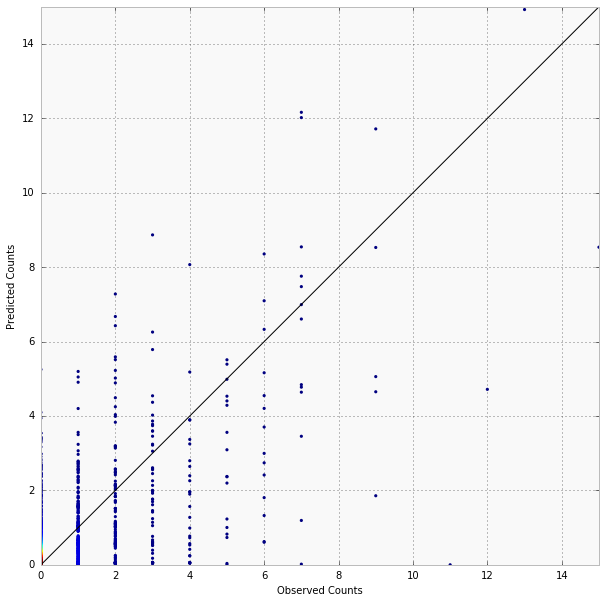

In [233]:
# Let's now plot the data : 

rmse_holdout_count=(rfm_with_holdout['model_holdout_count'] - rfm_with_holdout['obs_holdout_count']).apply(lambda x :x*x)
rmse_holdout_count=np.sqrt(rmse_holdout_count.sum()/len(rfm_with_holdout))
print('RMSE =', rmse_holdout_count)
plot_scatter(rfm_with_holdout, 'obs_holdout_count', 'model_holdout_count')

Not surprisingly we're not doing as well on the holdout set than we did on the training set. Not too bad though as the RMSE is approximately 1 purchase count. 

There are several ways to improve the holdout results. Segmentation is one of them. 

**<a href="http://www.datascience.com">DataScience</a>'s advisory services for our platform customers will guide you through the process of implementing and refining your CLV models and put them in production. **

# Training a simple Gamma-Gamma model on the monetary value 

The next steps is to look at the monetary value model. This model follows closely the Gamma-Gamma model discussed in Fader et al. (2004). Note that the monetary value component is generally very difficult to model. Many factors can affect the price of items in ways that are not accounted for by the model. Long term changes in prices over several years (akin to inflation), discounts, promotions, etc. are difficult to capture in this and other simple monetary value models. That is something to keep in mind when doing comparisons over the holdout period and making predictions for future purchases. 

In the gamma model, the observed average order value $m_x$ in the training period is an imperfect metric of the latent mean transaction value $E(M)$ at the customer level. 

**The main assumption behind the gamma model is that the average order value at the customer level is distributed according to a gamma distribution of shape $p$ and scale $\nu$**
$$ p(m_x~|~p, \nu, x) = \frac{(\nu x)^{px}m_x^{px-1}e^{-\nu x m_x}}{\Gamma(px)}$$

where 
* $x$ is the total number of transactions (`rfm['frequency']+1`) 
* $m_x$ is the average order value
* **$p$ is the shape of the gamma distribution. The model assumes that this parameter is the same for all customers.**
* $\nu$ is the scale parameter. $\nu$ varies across customers and has a prior that is also gamma distributed with parameters $(q,\gamma)$

The expectation value of the gamma distribution, which is the mean purchase value is $p/\nu$ in this case. The MCMC sampling technique gives us the posterior distribution of $\nu$. To get an estimate of $E(M)$ at the customer level, one simply has to average the value of $p/\nu$ over the MCMC trace values of $\nu$ and $p$, at the customer level. We go over the steps in the cells below. 

In [1]:
# This gamma-gamm model follows the Fader et al. (2004) Gamma-Gamma model closely. 
# Again, this model can take a while to train. Recommend a few 1000's iterations. 

gamma_gamma_model="""
data {
    // this is the data we pass to STAN : 
    int<lower=1> n_cust;         // number of customers 
    vector[n_cust] x;            // frequency + 1 
    vector[n_cust] mx;           // average purchase amount for each customer 
}

parameters {
    // These are the model parameters : 
    real <lower=0>p;             // scale parameter of the gamma distribution. Note that 
                                 // this parameter is not a vector. All customers will have the 
                                 // same value of p. 
    vector<lower=0> [n_cust] v;   // shape parameter of the gamma distribution (nu)
    real <lower=0>q;             // shape parameter of the gamma prior distribtion on v 
    real <lower=0>y;             // scale parameter of the gamma prior distribution on v 
}

transformed parameters {
    vector<lower=0> [n_cust] px;
    vector<lower=0> [n_cust] nx; 
    px <- p * x;                 // getting px from p and x 
    for (i in 1:n_cust) 
        nx[i] <- v[i] * x[i]; 
}

model {
    p ~ exponential(0.1);    // prior distribution on p
    q ~ exponential(0.5);    // hyperprior distribution on q 
    y ~ exponential(0.1);    // hyperprior distribution on y 
//    v ~ gamma(q, q ./ y);    // prior distribution on nu  
//    mx ~ gamma(px, v);       // likelihood function 
    v ~ gamma(q,y); 
    mx ~ gamma(px,nx); 
}
"""

# here's the data we will provide to STAN : 
data_gg={'n_cust':len(rfm),
    'x':rfm['frequency'].values+1.0,
    'mx':rfm['monetary_value'].values
     }

# I recommend training for several 1000's iterations. 
gamma_gamma_fit = stan_cache(gamma_gamma_model, model_name='gamma_gamma_model', \
                                  data=data_gg, chains=1, iter=1000, warmup=500)

NameError: name 'rfm' is not defined

In [234]:
# Here I extract the model parameters from the fit 

trace_gg = gamma_gamma_fit.extract()
nu = trace_gg['v']
p = trace_gg['p']
gamma = trace_gg['y']
q = trace_gg['q']

In [235]:
# Now let's compute E(M) and join it to the rfm object :
pvalues = np.tile(np.array(p).T,(len(rfm),1))
E_M = (pvalues / nu.T).mean(axis=1)

In [236]:
# Now let's compute E(M) and join it to the rfm object : 

rfm['E_M'] = E_M

In [237]:
rfm[['monetary_value', 'E_M']].head()

,monetary_value,E_M
cust,,
4,23.723333,25.124069
18,14.960000,21.401881
21,37.555000,36.345113
50,6.790000,16.489899
60,21.750000,26.573135


## Comparisons between E(M) and observed mean in training period 

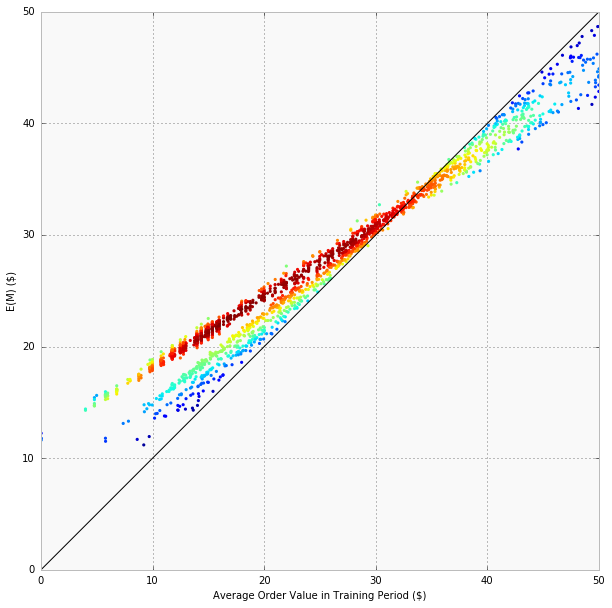

In [238]:
# Let's explore the results : 

plot_scatter(rfm,'monetary_value','E_M', 
             xlabel='Average Order Value in Training Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[0,50], ylim=[0,50])

In the figure above, what can be perceived as different "lines" correspond to different values of "x". 

## Comparisons between E(M) and observed mean in holdout/validation period 

In [239]:
# Let's compute the observed mean transaction value per customer in the holdout period : 

holdout_value = holdout.groupby(['cust', 'date'], as_index=False)['sales'].sum().reset_index()
holdout_value = holdout_value[['cust', 'sales']].groupby(['cust'])['sales'].mean()
holdout_value=pd.DataFrame(holdout_value)
holdout_value.rename(columns={'sales':'obs_holdout_monetary_value'}, inplace=True)
holdout_value.head()

,obs_holdout_monetary_value
cust,
111,65.486667
113,13.380000
114,28.735000
166,11.750000
208,70.380000


In [240]:
# merge with rfm object : 
rfm_w_holdout_value  = rfm.merge(holdout_value, how='left', left_index=True, right_index=True)
rfm_w_holdout_value.fillna(0,inplace=True)

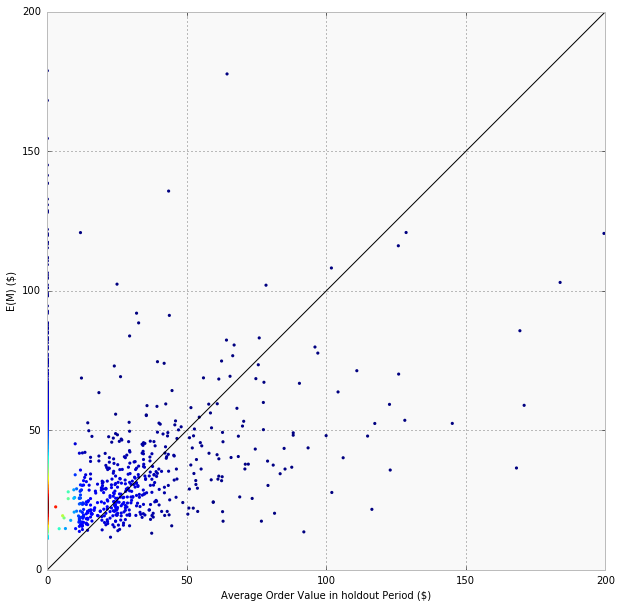

In [241]:
plot_scatter(rfm_w_holdout_value,'obs_holdout_monetary_value','E_M', 
             xlabel='Average Order Value in holdout Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[0,200], ylim=[0,200])

In [242]:
rfm['E_M'].mean()

33.155613399908844

In [243]:
holdout_value.mean()

obs_holdout_monetary_value    37.518947
dtype: float64

This chart above highlights how difficult it is to accurately model the monetary value. The points found along the observed value of 0 corresponds to customers who have not made a purchase in the holdout period. For the customers who have made at least one purchase in the holdout period, our model tends to underestimate the mean value that these users will spend in that period. 

# Finally, computing the CLV in the holdout period and comparing with with model predictions 

We are at the end of this exercise. The last step is to compute the customer-level CLV predictions for the holdout period. I invite you to do the same comparison for the training period. 

CLV is obtained by 
$$CLV(t,t+dt) = E(M)~\times~ E[Y(dt)~|~\lambda, \mu, x, t_x, T] $$

In [244]:
# compute both modeled and observed CLV in the holdout period : 

rfm['model_holdout_clv'] = rfm_with_holdout['model_holdout_count'] * rfm['E_M']
rfm['obs_holdout_clv'] = rfm_with_holdout['obs_holdout_count'] * rfm_w_holdout_value['obs_holdout_monetary_value']
rmse_holdout_clv = (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])* \
                   (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])
rmse_holdout_clv = np.sqrt(rmse_holdout_clv.sum()/len(rfm))

('RMSE =', 50.906531530555085)


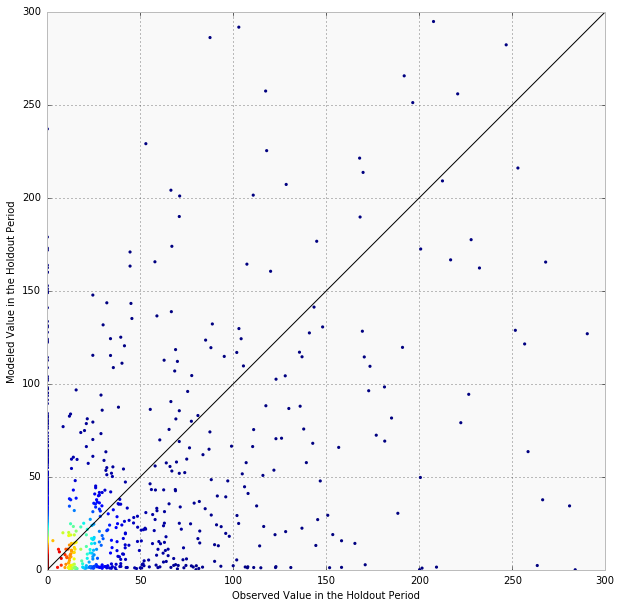

In [245]:
# plot the final results : 
print('RMSE =', rmse_holdout_clv)
plot_scatter(rfm, 'obs_holdout_clv', 'model_holdout_clv',
             xlabel='Observed Value in the Holdout Period',
             ylabel='Modeled Value in the Holdout Period', 
             xlim=[0,300.0],ylim=[0,300.0])

# In conclusion 

The Pareto/NBD model is a good introduction to CLV modeling. The gamma-gamma model for monetary value is easy and simple to train. 

There are however several limitations to these approaches. More sophisticated models could include user segmentation. Bayes hierarchical models may also be able to better discriminate groups of customers who exhibit different behaviors and model their $\lambda$ and $\mu$ accordingly. 

The team of data scientists at DataScience can help you designing and improve these models. For our DataScience Cloud Platform customers, we provide a CLV playbook along with a library of CLV models, diagnostics and support. 